In [1]:

import brainpy.math as bm
import numpy as np
from PCCAN_utils import get_tuningMap, animate_sweeps
from models import PC_cell_topdown, PC_cell_topdown_asym

#for generting behavioral trajectory
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

#for plotting
import matplotlib.pyplot as plt
#grid spec
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import seaborn as sns
import time
from scipy.ndimage import gaussian_filter

import os
from scipy.signal import find_peaks
from scipy.ndimage import center_of_mass
from scipy.stats import pearsonr

import sys
sys.path.append('/home/zilong/Desktop/HoneycombSweeps/CircularLinearReg')
from core import cl_corr


%matplotlib inline  
%load_ext autoreload 
%autoreload 2

[]

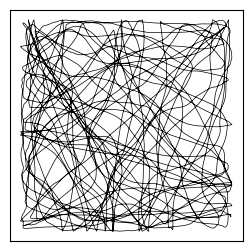

In [2]:
np.random.seed(111)

Env = Environment(params={
    'scale':1,
    "dimensionality": "2D",
})

dur = 400 #in seconds
dt = 0.001 #in seconds
speed_mean = 0.2 #in m/s
speed_std = 0.0 #in m/s
rot = 60
rotation_velocity_std = rot * (np.pi / 180) #in rad/s

#if traj exist, load it, otherwise generate it
if os.path.exists('./traces/Traj_dur'+str(dur)+'_speedMean'+str(speed_mean)+'_rot'+str(rot)+'.npz'):
    data = np.load('./traces/Traj_dur'+str(dur)+'_speedMean'+str(speed_mean)+'_rot'+str(rot)+'.npz')
    Position = data['Position'] #add 0,5 is to make the running rat in the middle of the box [from 0.5 to 1.5], the size of the neuronal sheet is 2by2. we did so to remove the periodic boundary effect
    Speed = data['Speed']
    Vel = data['Velocity']
else:
    Ag = Agent(Env, params = {
        "dt": dt,
        "speed_mean":speed_mean,
        "speed_std": speed_std,
        "rotational_velocity_std": rotation_velocity_std, #set to 120 or 360 will change the tutoriocity of the trajectory
        })

    while Ag.t < dur:
        Ag.update(drift_velocity=None)

    Position = Ag.history['pos'] 
    Position = np.array(Position) + 0.5 #add 0,5 is to make the running rat in the middle of the box [from 0.5 to 1.5], the size of the neuronal sheet is 2by2. we did so to remove the periodic boundary effect
    # Position_2_2pi = Position*(2*np.pi)-np.pi
    Vel = Ag.history['vel']
    Vel = np.array(Vel)
    Speed = np.linalg.norm(Vel, axis=1) * dt # meters per ms
    
    #calculate moving direction from Vel whihc is (x,y) at each time step
    moving_direction = np.zeros(len(Vel))
    for i in range(len(Vel)):
        moving_direction[i] = np.arctan2(Vel[i][1], Vel[i][0])
    
    np.savez('./traces/Traj_dur'+str(dur)+'_speedMean'+str(speed_mean)+'_rot'+str(rot)+'.npz', Position=Position, Speed=Speed, Velocity=Vel, Direction=moving_direction, dur=dur)

fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.plot(Position[:,0], Position[:,1], linewidth=0.5, color='black')
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])


In [3]:
#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0) #ms
bm.clear_buffer_memory(platform='gpu')

#hyperparameters
m0 = 12 #adaptation strength #10
z_min = 0; z_max = 2 #the size of the environment, have to be the same as the environment size
duration = int(dur/dt) #simulation duration of the trajectory
alpha_pc = 0.5 #theta modulation scale
v0 = 1/1000 #baseline speed per ms  
T_theta = 100 #ms, length of a theta cycle; frequency=10Hz
num = 50 #number of PC cells on x or y axis
goal_loc = [0.75, 0.75]

PC_net = PC_cell_topdown_asym(num=num, 
                        tau=10, 
                        tauv=150, 
                        m0=m0, 
                        k=1, 
                        a=0.18, 
                        A=10.0, 
                        J0=8.0, 
                        goal_a=0.6,
                        goal_b=1.0,
                        goal_A=4.0,
                        asym_J0 = 0.1,
                        asym_a = 0.5,
                        z_min=z_min, 
                        z_max=z_max,    
                        conn_noise=0.0, 
                        rec_noise=0.0,     
                        goal_loc=goal_loc,
                        topdown=True,
                        asymmetry=False,
                        tdstyle='Gaussian')

def runNet(i, Animal_location, Speed):
    theta_mod_strength = alpha_pc * 1/v0 * Speed #faster run, higher theta modulation strength
    #calculate thetamodulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta
    ThetaModulator_BU = 0.5+theta_mod_strength*bm.cos(theta_phase*2*bm.pi) #0.5  #0.2
    Topdown_mod = 1.2 #0.6 #1+theta_mod_strength*bm.cos(theta_phase*2*bm.pi + bm.pi) #1.2 #0.6 for phase precession
    
    #update place cell network using step_run
    PC_net.step_run(i, Animal_location, ThetaModulator_BU, Topdown_mod)
    
    #get intermidiate results
    pc_activity = PC_net.r
    pc_bumcenter = PC_net.center
    return pc_activity, pc_bumcenter, theta_phase, ThetaModulator_BU

time_steps = np.arange(len(Position))
print('Running simulation...')

@bm.jit
def run(time, pos, speed):
    return bm.for_loop(runNet, (time, pos, speed))

# pc_activity, pc_bumpcenter, theta_phase, theta_rhythm= bm.for_loop(runNet, (time_steps, Position, Speed))
simulate_time = 50000  #every 50s perform the simulation, otherwise the gpu will run out of memory 

# Pre-allocate arrays
pc_activity = np.empty((len(Position), num, num))
pc_bumpcenter = np.empty((len(Position), 2))
theta_phase = np.empty(len(Position))
theta_rhythm = np.empty(len(Position))

for i in range(0, len(Position), simulate_time):
    print('Simulation progress: %.0f%%' % (i/len(Position)*100))
    pc_activity_i, pc_bumpcenter_i, theta_phase_i, theta_rhythm_i = run(time_steps[i:i+simulate_time], Position[i:i+simulate_time], Speed[i:i+simulate_time])
    #send data to cpu and store them
    pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i)
    pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)
    theta_phase[i:i+simulate_time] = np.asarray(theta_phase_i)
    theta_rhythm[i:i+simulate_time] = np.asarray(theta_rhythm_i)

2025-01-24 14:30:04.383972: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Running simulation...
Simulation progress: 0%
Simulation progress: 12%
Simulation progress: 25%
Simulation progress: 37%
Simulation progress: 50%
Simulation progress: 62%
Simulation progress: 75%
Simulation progress: 87%
Simulation progress: 100%


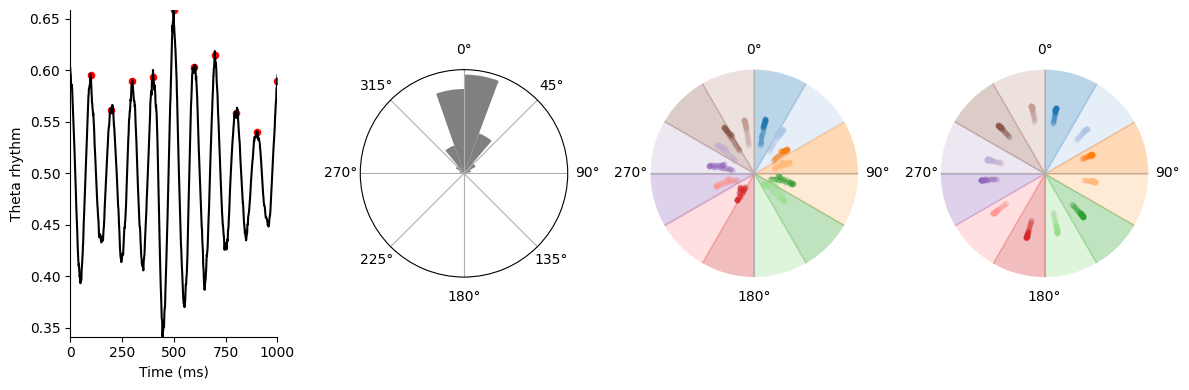

In [6]:
#find peak using scipy.signal.find_peaks
peaks, _ = find_peaks(theta_phase)

#plot theta_rhythm and mark peaks as red dots
# fig, axs = plt.subplots(1, 3, figsize=(10, 3), dpi=100)
#gridspec
fig = plt.figure(figsize=(12, 4), dpi=100)
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])

ax = plt.subplot(gs[0])
ax.plot(theta_rhythm, color='black')
ax.scatter(peaks, theta_rhythm[peaks], color='red', s=20)
ax.set_xlim(0, 1000)
ax.set_ylim(np.min(theta_rhythm[:1000]), np.max(theta_rhythm[:1000]))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Theta rhythm')
sns.despine()

Angle_at_zeroPhase = []
BumpAngle_2_goal = [] #same dime as Angle_at_zeroPhase
BumpAngle_at_all_phase = []
BumpDist_2_pos = []
BumpDist_2_pos_centermass = []
BumpAngle_at_all_phase_centermass = []

#at each peak, calculate the angle between moving direction and the vector from the Position to the goal location
for i in range(len(peaks)-1):
    #calculate the vector from the Position to the goal location
    vec = np.array([goal_loc[0] - Position[peaks[i], 0], goal_loc[1] - Position[peaks[i], 1]])
    #calculate the angle between from vector to the moving direction
    angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
    angle = np.degrees(angle) % 360
    Angle_at_zeroPhase.append(angle)
    
    bumpTraj_in_Acycle = pc_bumpcenter[peaks[i]:peaks[i+1], :]/num * z_max
    BumpAngle = []
    BumpDist = []
    BumpAngle_cm = []
    BumpDist_cm = []
    for j in range(len(bumpTraj_in_Acycle)):
        
        #calculate the angle between sweeps and Position at the peak (zero phase)
        vec2 = np.array([bumpTraj_in_Acycle[j, 0] - Position[peaks[i], 0], bumpTraj_in_Acycle[j, 1] - Position[peaks[i], 1]])
        # Calculate sweep angle relative to goal
        angle2 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(vec[1], vec[0])
        angel2 = np.degrees(angle2) % 360
        BumpAngle_2_goal.append(angle2)
        
        #calculate the angle between sweeps and moving direction
        angle3 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
        angle3 = np.degrees(angle3) % 360
        BumpAngle.append(angle3)
        
        #calculate bump distance to the position
        dist = np.linalg.norm(vec2)
        # dist = np.where(dist > 0.5, 1.0 - dist, dist)
        BumpDist.append(dist)
        
        #calculate pc_activity[peaks[i]+j, :, :] center of mass
        bump = pc_activity[peaks[i]+j, :, :]
        center1, center0 = center_of_mass(bump)
        center1 = center1/num * z_max
        center0 = center0/num * z_max
        vec_cm = np.array([center0 - Position[peaks[i], 0], center1 - Position[peaks[i], 1]])
        dist_cm = np.linalg.norm(vec_cm)
        BumpDist_cm.append(dist_cm)
        
        #calculate the angle between sweeps from center of mass and and moving direction
        angle4 = np.arctan2(vec_cm[1], vec_cm[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
        angle4 = np.degrees(angle4) % 360
        BumpAngle_cm.append(angle4)
        
        
    BumpAngle_at_all_phase.append(BumpAngle)
    BumpAngle_at_all_phase_centermass.append(BumpAngle_cm)
    BumpDist_2_pos.append(BumpDist)
    BumpDist_2_pos_centermass.append(BumpDist_cm)

ax = plt.subplot(gs[1], projection='polar') 
ax.hist(BumpAngle_2_goal, bins=36, color='grey')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])

####################################################################################################

ax = plt.subplot(gs[2], projection='polar')
ax.set_yticks([])
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_ylim(0, 0.2)
ax.spines['polar'].set_visible(False)
#plasce 0 at the top
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
#initialize 12 colors from tab20
colors = sns.color_palette("tab20", 12)
#color 1 to 12 rerpesent degree range of 0-30, 30-60, etc

# Shade each sector of the polar plot with the respective color
for i in range(360 // 30):
    ax.fill_between([np.radians(i * 30), np.radians((i + 1) * 30)], 0, 1, color=colors[i], alpha=0.3)

scatter_angles = []
scatter_angles_cm = []
scatter_distances = []
scatter_distances_cm = []
scatter_colors = []
scatter_alphas = []

sweep_info = {}

#clasifiy sweeps into 12 bins with 30 degree each
for goal_ang, sweep_angs, sweep_dist, sweep_angs_cm, sweep_dist_cm in zip(Angle_at_zeroPhase, BumpAngle_at_all_phase, BumpDist_2_pos, BumpAngle_at_all_phase_centermass, BumpDist_2_pos_centermass):
    goal_ang = goal_ang % 360
    indx = int(goal_ang // 30)
    #append sweep_angs and sweep_dist to a dictionary with indx as key
    if indx not in sweep_info:
        sweep_info[indx] = []
    sweep_info[indx].append((sweep_angs, sweep_dist, sweep_angs_cm, sweep_dist_cm))

#in each angular bin, calculate the mean sweep angle and distance
for key in sweep_info:
    sweep_info_key = sweep_info[key]
    SA = []
    SD = []
    SA_cm = []
    SD_cm = []
    for sweep_angs, sweep_dist, sweep_angs_cm, sweep_dist_cm in sweep_info_key:
        start = 15; end = 85 #extract a middle period as Changmin did in empirical data analysis
        SA.append(sweep_angs[start:end])
        SD.append(sweep_dist[start:end])
        SA_cm.append(sweep_angs_cm[start:end])
        SD_cm.append(sweep_dist_cm[start:end])
    #to numpy array using stack
    SA = np.stack(SA)
    SD = np.stack(SD)
    SA_cm = np.stack(SA_cm)
    SD_cm = np.stack(SD_cm)
    
    # Convert angles in SA to complex numbers
    complex_angles = np.exp(1j * np.radians(SA))  # Convert angles to radians and then to complex form
    mean_complex = np.mean(complex_angles, axis=0)  # Calculate mean in complex plane
    SA_mean = np.degrees(np.angle(mean_complex)) % 360  # Convert back to degrees and wrap to 0-360
    
    complex_angles_cm = np.exp(1j * np.radians(SA_cm))  # Convert angles to radians and then to complex form
    mean_complex_cm = np.mean(complex_angles_cm, axis=0)  # Calculate mean in complex plane
    SA_cm_mean = np.degrees(np.angle(mean_complex_cm)) % 360  # Convert back to degrees and wrap to 0-360
    
    # Calculate mean distance
    SD_mean = np.mean(SD, axis=0)
    SD_cm_mean = np.mean(SD_cm, axis=0)
    
    # Store points for batch scatter plot

    for i, (ang, dist, ang_cm, dist_cm) in enumerate(zip(SA_mean, SD_mean, SA_cm_mean, SD_cm_mean)):
        scatter_angles.append(np.radians(ang))
        scatter_distances.append(dist)
        scatter_angles_cm.append(np.radians(ang_cm))
        scatter_distances_cm.append(dist_cm)
        scatter_colors.append(colors[key])
        alpha = i/len(SA_mean)/5
        scatter_alphas.append(alpha)
    


#plot mean sweep agle and distance in each angular bin
for i in range(len(scatter_angles)):
    ax.scatter(scatter_angles[i], scatter_distances[i], color=scatter_colors[i], s=10, alpha=scatter_alphas[i])


####################################################################################################

ax = plt.subplot(gs[3], projection='polar')
ax.set_yticks([])
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_ylim(0, 0.5)
ax.spines['polar'].set_visible(False)
#plasce 0 at the top
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
#initialize 12 colors from tab20
colors = sns.color_palette("tab20", 12)
#color 1 to 12 rerpesent degree range of 0-30, 30-60, etc

# Shade each sector of the polar plot with the respective color
for i in range(360 // 30):
    ax.fill_between([np.radians(i * 30), np.radians((i + 1) * 30)], 0, 1, color=colors[i], alpha=0.3)
    
#plot mean sweep agle and distance in each angular bin
for i in range(len(scatter_angles_cm)):
    ax.scatter(scatter_angles_cm[i], scatter_distances_cm[i], color=scatter_colors[i], s=10, alpha=scatter_alphas[i])
plt.tight_layout()

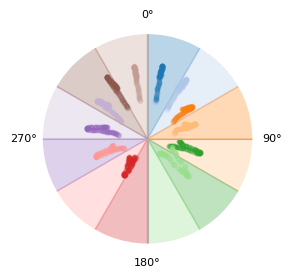

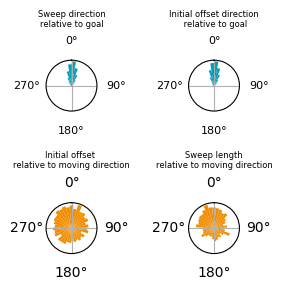

In [5]:
#find peak using scipy.signal.find_peaks
peaks, _ = find_peaks(theta_phase)
#plot theta_rhythm and mark peaks as red dots
# fig, axs = plt.subplots(1, 3, figsize=(10, 3), dpi=100)
#gridspec


start=15; end=85

Angle_at_zeroPhase = []
BumpAngle_2_goal = [] #same dime as Angle_at_zeroPhase
BumpAngle_at_all_phase = []
BumpDist_2_pos = []
InitOffsetAngle2goal = []
InitOffsetDist = []
InitOffsetAngle2md = []
SweepLength = []

#at each peak, calculate the angle between moving direction and the vector from the Position to the goal location
for i in range(len(peaks)-1):
    #calculate the vector from the Position to the goal location
    vec = np.array([goal_loc[0] - Position[peaks[i], 0], goal_loc[1] - Position[peaks[i], 1]])
    #calculate the angle between from vector to the moving direction
    angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
    angle = np.degrees(angle) % 360
    Angle_at_zeroPhase.append(angle)
    
    bumpTraj_in_Acycle = pc_bumpcenter[peaks[i]:peaks[i+1], :]/num * z_max
    
    #using 20th point as initial offset
    init_offset_loc = bumpTraj_in_Acycle[start,:]
    #calculate the vect from offset loc to position 
    init_offset_vec = np.array([init_offset_loc[0] - Position[peaks[i], 0], init_offset_loc[1] - Position[peaks[i], 1]])
    #init offset dist
    int_offset_dist = np.linalg.norm(init_offset_vec)
    InitOffsetDist.append(int_offset_dist)
    
    #calculate the angle between offset_vec and direction to goal
    init_offset_angle = np.arctan2(init_offset_vec[1], init_offset_vec[0]) - np.arctan2(vec[1], vec[0])
    InitOffsetAngle2goal.append(init_offset_angle)
    
    #calculate the angle between offset_vec and moving direction
    init_offset_angle2md = np.arctan2(init_offset_vec[1], init_offset_vec[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
    InitOffsetAngle2md.append(init_offset_angle2md)
    
    #calculate sweep length as difference between bumpTraj_in_Acycle[20,:] and bumpTraj_in_Acycle[70,:]
    #calculate sweep length as 
    dist_in_acyle = np.linalg.norm(bumpTraj_in_Acycle[start:end, :]-Position[peaks[i], :], axis=1)
    # sweep_length = np.max(dist_in_acyle) - np.min(dist_in_acyle)
    sweep_length = np.linalg.norm(bumpTraj_in_Acycle[start,:] - bumpTraj_in_Acycle[end,:])
    SweepLength.append(sweep_length)
    
    BumpAngle = []
    BumpDist = []
    for j in range(len(bumpTraj_in_Acycle)):
        #calculate the angle between sweeps and Position at the peak (zero phase)
        vec2 = np.array([bumpTraj_in_Acycle[j, 0] - Position[peaks[i], 0], bumpTraj_in_Acycle[j, 1] - Position[peaks[i], 1]])
        # Calculate sweep angle relative to goal
        angle2 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(vec[1], vec[0])
        BumpAngle_2_goal.append(angle2)
        
        #calculate the angle between sweeps and moving direction
        angle3 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
        angle3 = np.degrees(angle3) % 360
        BumpAngle.append(angle3)
        
        #calculate bump distance to the position
        dist = np.linalg.norm(vec2)
        # dist = np.where(dist > 0.5, 1.0 - dist, dist)
        BumpDist.append(dist)
    BumpAngle_at_all_phase.append(BumpAngle)
    BumpDist_2_pos.append(BumpDist)

####################################################################################################

fig = plt.figure(figsize=(3, 3), dpi=100)
gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0], projection='polar')
ax.set_yticks([])
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_ylim(0, 0.15)
ax.spines['polar'].set_visible(False)
#plasce 0 at the top
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
#initialize 12 colors from tab20
colors = sns.color_palette("tab20", 12)
#color 1 to 12 rerpesent degree range of 0-30, 30-60, etc

# Shade each sector of the polar plot with the respective color
for i in range(360 // 30):
    ax.fill_between([np.radians(i * 30), np.radians((i + 1) * 30)], 0, 1, color=colors[i], alpha=0.3)

scatter_angles = []
scatter_distances = []
scatter_colors = []
scatter_alphas = []

sweep_info = {}

#clasifiy sweeps into 12 bins with 30 degree each
for goal_ang, sweep_angs, sweep_dist in zip(Angle_at_zeroPhase, BumpAngle_at_all_phase, BumpDist_2_pos):
    goal_ang = goal_ang % 360
    indx = int(goal_ang // 30)
    #append sweep_angs and sweep_dist to a dictionary with indx as key
    if indx not in sweep_info:
        sweep_info[indx] = []
    sweep_info[indx].append((sweep_angs, sweep_dist))

#in each angular bin, calculate the mean sweep angle and distance
for key in sweep_info:
    sweep_info_key = sweep_info[key]
    SA = []
    SD = []
    for sweep_angs, sweep_dist in sweep_info_key:
        
        SA.append(sweep_angs[start:end])
        SD.append(sweep_dist[start:end])
    #to numpy array using stack
    SA = np.stack(SA)
    SD = np.stack(SD)
    
    # Convert angles in SA to complex numbers
    complex_angles = np.exp(1j * np.radians(SA))  # Convert angles to radians and then to complex form
    mean_complex = np.mean(complex_angles, axis=0)  # Calculate mean in complex plane
    SA_mean = np.degrees(np.angle(mean_complex)) % 360  # Convert back to degrees and wrap to 0-360
    
    # Calculate mean distance
    SD_mean = np.mean(SD, axis=0)
    
    # Store points for batch scatter plot
    for i, (ang, dist) in enumerate(zip(SA_mean, SD_mean)):
        scatter_angles.append(np.radians(ang))
        scatter_distances.append(dist)
        scatter_colors.append(colors[key])
        alpha = i/len(SA_mean)/2
        scatter_alphas.append(alpha)

#plot mean sweep agle and distance in each angular bin
for i in range(len(scatter_angles)):
    ax.scatter(scatter_angles[i], scatter_distances[i], color=scatter_colors[i], s=10, alpha=scatter_alphas[i])

#ticksize to 8
ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()

plt.savefig('./figures/GDSweeps_part1.pdf', dpi=300)

fig = plt.figure(figsize=(3, 3), dpi=100)
gs = gridspec.GridSpec(2, 2)
####################################################################################################
ax = plt.subplot(gs[0,0], projection='polar') 
ax.hist(BumpAngle_2_goal, bins=72, color='#009FB9')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_title('Sweep direction\nrelative to goal', fontsize=6)

#tickszie to 8
ax.tick_params(axis='both', which='major', labelsize=8)

####################################################################################################
ax = plt.subplot(gs[0,1], projection='polar') 
ax.hist(InitOffsetAngle2goal, bins=72, color='#009FB9')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_title('Initial offset direction\n relative to goal', fontsize=6)

#tickszie to 8
ax.tick_params(axis='both', which='major', labelsize=8)

####################################################################################################
ax = plt.subplot(gs[1,0], projection='polar')
#plot InitOffsetAngle2md vs InitOffsetDist as a bar plot
# ax.scatter(InitOffsetAngle2md, InitOffsetDist, color='#009FB9', s=10, alpha=0.01)
bins = np.linspace(-2*np.pi, 2*np.pi, 36)
#calculate the mean distance in each bin
mean_dist = []
for i in range(len(bins)-1):
    indx = np.where((InitOffsetAngle2md >= bins[i]) & (InitOffsetAngle2md < bins[i+1]))
    mean_dist.append(np.mean(np.array(InitOffsetDist)[indx]))
ax.bar(bins[:-1], mean_dist, width=2*np.pi/36, color='#F18D00', alpha=1.0)

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_title('Initial offset \nrelative to moving direction', fontsize=6)

####################################################################################################\
#plot sweep length vs InitOffsetAngle2md
ax = plt.subplot(gs[1,1], projection='polar')
bins = np.linspace(-2*np.pi, 2*np.pi, 36)
#calculate the mean distance in each bin
mean_sweep_length = []
for i in range(len(bins)-1):
    indx = np.where((InitOffsetAngle2md >= bins[i]) & (InitOffsetAngle2md < bins[i+1]))
    mean_sweep_length.append(np.mean(np.array(SweepLength)[indx]))
ax.bar(bins[:-1], mean_sweep_length, width=2*np.pi/36, color='#F18D00', alpha=1.0)

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_title('Sweep length\nrelative to moving direction', fontsize=6)


plt.tight_layout()

plt.savefig('./figures/GDSweeps_part2.pdf', dpi=300)

## Check phase precerssion relative to the distance to the goal

### get the continuous toward and away periods

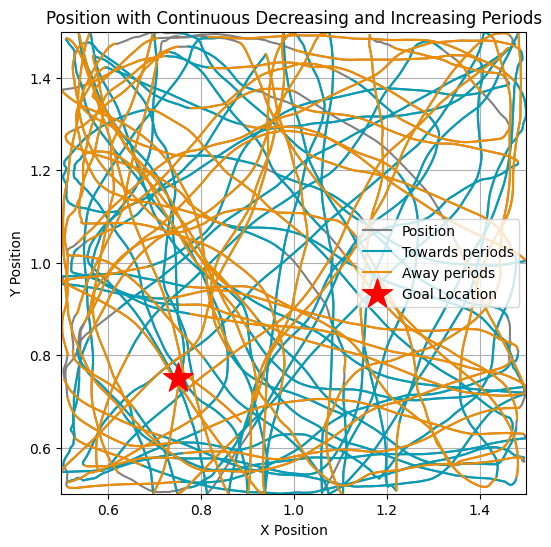

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def find_periods(Position, goal_loc, threshold=1000):
    """
    Finds continuous periods where the distance to goal_loc is either decreasing or increasing 
    for at least `threshold` points.

    Parameters:
    - Position (ndarray): Array of positions (Nx2 or Nx3 for 2D or 3D positions).
    - goal_loc (ndarray): Goal location as an array (2D or 3D).
    - threshold (int): Minimum length of a continuous period to consider.

    Returns:
    - decreasing_periods (list): List of tuples (start_index, end_index) for valid decreasing periods.
    - increasing_periods (list): List of tuples (start_index, end_index) for valid increasing periods.
    """
    decreasing_periods = []
    increasing_periods = []
    current_start = None
    decreasing_count = 0
    increasing_count = 0
    mode = None  # Tracks whether we're in a decreasing or increasing phase

    for i in range(1, len(Position)):
        dist_prev = np.linalg.norm(Position[i-1] - goal_loc)
        dist_curr = np.linalg.norm(Position[i] - goal_loc)

        if dist_curr < dist_prev:  # Distance is decreasing
            if mode != "decreasing":
                # End previous increasing period
                if increasing_count >= threshold:
                    increasing_periods.append((current_start, current_start + increasing_count))
                current_start = i - 1
                increasing_count = 0
                mode = "decreasing"
            decreasing_count += 1
        elif dist_curr > dist_prev:  # Distance is increasing
            if mode != "increasing":
                # End previous decreasing period
                if decreasing_count >= threshold:
                    decreasing_periods.append((current_start, current_start + decreasing_count))
                current_start = i - 1
                decreasing_count = 0
                mode = "increasing"
            increasing_count += 1
        else:
            # Distance is constant or ambiguous, reset counters and handle ending periods
            if mode == "decreasing" and decreasing_count >= threshold:
                decreasing_periods.append((current_start, current_start + decreasing_count))
            elif mode == "increasing" and increasing_count >= threshold:
                increasing_periods.append((current_start, current_start + increasing_count))
            current_start = None
            decreasing_count = 0
            increasing_count = 0
            mode = None

    # Final check after the loop ends
    if mode == "decreasing" and decreasing_count >= threshold:
        decreasing_periods.append((current_start, current_start + decreasing_count))
    elif mode == "increasing" and increasing_count >= threshold:
        increasing_periods.append((current_start, current_start + increasing_count))

    return decreasing_periods, increasing_periods


# Example usage:
decreasing_periods, increasing_periods = find_periods(Position, goal_loc, threshold=500)

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(Position[:, 0], Position[:, 1], color='grey', label='Position')  # Plot Position in grey

# Highlight decreasing periods in red
for start, end in decreasing_periods:
    plt.plot(Position[start:end+1, 0], Position[start:end+1, 1], color='#009FB9', label='Towards periods' if start == decreasing_periods[0][0] else "")

# Highlight increasing periods in blue
for start, end in increasing_periods:
    plt.plot(Position[start:end+1, 0], Position[start:end+1, 1], color='#F18D00', label='Away periods' if start == increasing_periods[0][0] else "")

plt.scatter(goal_loc[0], goal_loc[1], color='red', marker='*', label='Goal Location', zorder=5, s=500)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Position with Continuous Decreasing and Increasing Periods')
plt.xlim(0.5, 1.5)
plt.ylim(0.5, 1.5)
plt.legend()
plt.grid()
plt.show()


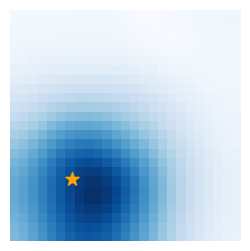

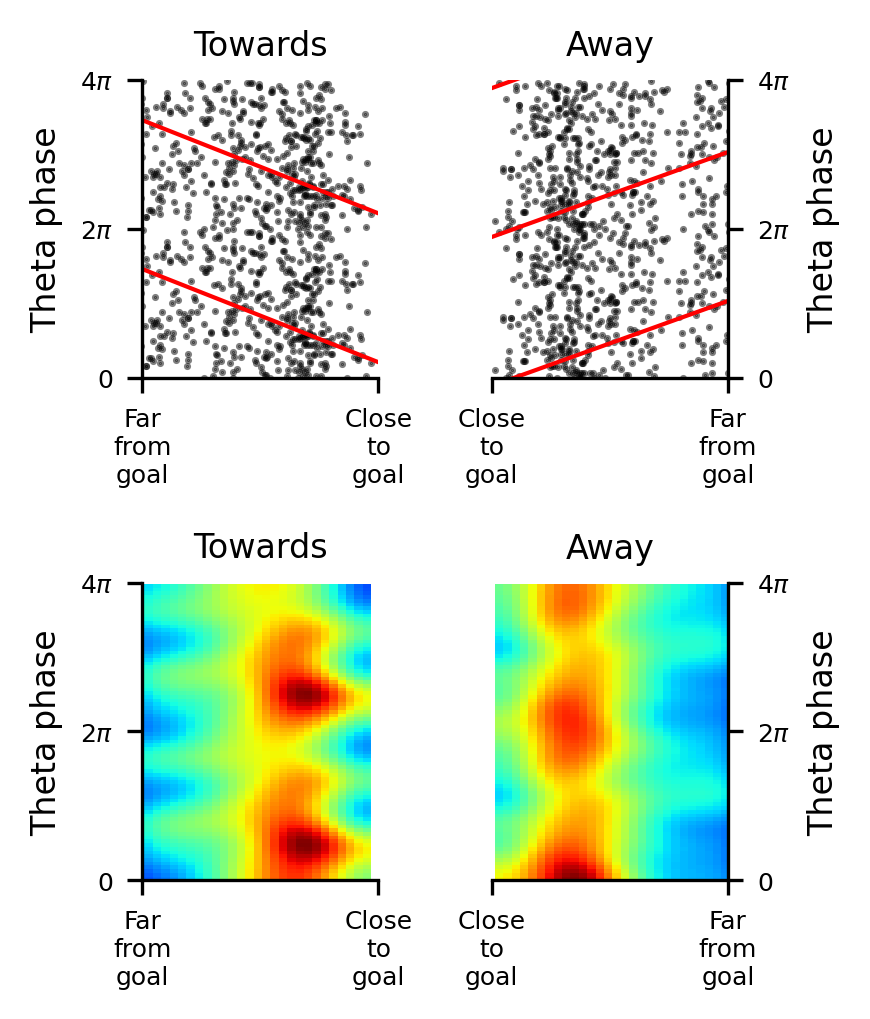

In [11]:
# variable needed: cellindex, pc_activity, Position, goal_loc, theta_phase
np.random.seed(123)   
addfitline = True

xlim = 0.7


fig = plt.figure(figsize=(3, 3), dpi=100)
gs = gridspec.GridSpec(1, 1)

# cellindex = [20, 22] #[21,24]#[21, 18]
cellindex = [21, 18]


ax = plt.subplot(gs[0])
#tuning map of a cell

Position_norm = (Position - Position.min() - 1e-5)/(Position.max() - Position.min())
dim = num//2
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          shift = 0,
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)
ax.imshow(tuningMap, cmap='Blues', origin='lower')

#mark the goal location
goal_x = (goal_loc[0]- Position.min())/(Position.max() - Position.min())*dim
goal_y = (goal_loc[1]- Position.min())/(Position.max() - Position.min())*dim

ax.scatter(goal_x, goal_y, color='Orange', marker='*', s=100)

ax.axis('off')


####################################################################################################

fig = plt.figure(figsize=(3,3.5), dpi=300)
gs = gridspec.GridSpec(2, 2)

#Phase against distance to goal

ax = plt.subplot(gs[0,0])
Dist2G = []
SpikePhase = []
RelativeDirection = []

r = pc_activity[:, cellindex[0], cellindex[1]] * 1000 #ms to s

for start, end in decreasing_periods:
    for i in range(start, end):
        #get the distance to goal_loc
        dist_i = np.linalg.norm(Position[i] - goal_loc)

        #get the vec pointing from Position to goal_loc
        vec = goal_loc - Position[i]
        #get the angle between vec and moving direction
        angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[i, 1], Vel[i, 0])
        angle = np.degrees(angle) % 360

        #get the phase at current time step i
        phase_i = theta_phase[i]*np.pi*2

        spikes = np.random.poisson(r[i]*dt*2)
        if spikes > 0:
            #save dist_i and phase_i
            Dist2G.append(dist_i)
            SpikePhase.append(phase_i)
            RelativeDirection.append(angle)


Dist2G = np.asarray(Dist2G)
SpikePhase = np.asarray(SpikePhase)

ax.scatter(Dist2G, SpikePhase, s=0.5, color='black', alpha=0.5)

ax.scatter(Dist2G, SpikePhase+2*np.pi, s=0.5, color='black', alpha=0.5)
# Create a 2D histogram for heat map

circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=0, max_slope=2, bootstrap_iter=3000, return_pval=True)

if addfitline:
    # Plot the circular-linear regression
    x = np.linspace(0, 1, 100)
    y = 2 * np.pi * slope * x + phi0
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 4*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #substrac intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)  

ax.set_xlim(0, xlim)
ax.set_xticks([0, xlim])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])

#flip x axis with small values on the right and large values on the left
# Flip the x-axis
ax.invert_xaxis()

# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
ax.set_ylabel('Theta phase', fontsize=8)
# #activity colorba
ax.set_ylim(0, 4*np.pi)
ax.set_yticks([0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   
ax.set_title('Towards', fontsize=8)

sns.despine()


####################################################################################################
ax = plt.subplot(gs[1,0])

# Combine SpikePhase and SpikePhase+2*np.pi to handle circular smoothing
SpikePhase_combined = np.concatenate([SpikePhase, SpikePhase + 2 * np.pi])
Dist2G_combined = np.concatenate([Dist2G, Dist2G])  # Repeat Dist2G to match

# Create a histogram with bins spanning the full range, including the repeated phase
heatmap, xedges, yedges = np.histogram2d(
    Dist2G_combined,
    SpikePhase_combined,
    bins=[40, 80],  # Double the bins in the y-direction for circularity
)

# Smooth the heatmap using a Gaussian filter
heatmap_smooth = gaussian_filter(heatmap, sigma=4)

# # Trim the heatmap back to the original range (0 to 4*np.pi)
# heatmap_smooth = heatmap_smooth[:, :40] + heatmap_smooth[:, 40:]  # Combine overlapping bins

# Generate the mesh grid for plotting
X, Y = np.meshgrid(xedges, yedges)  # Keep only the original y-axis range

# Plot the smoothed heatmap
pcm = ax.pcolormesh(X, Y, heatmap_smooth.T, shading='auto', cmap='jet')

#flip x axis with small values on the right and large values on the left
# Flip the x-axis


ax.set_xlim(0, xlim)
ax.set_xticks([0, xlim])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])

ax.invert_xaxis()

# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=18
ax.set_ylabel('Theta phase', fontsize=8)
# #activity colorba
ax.set_ylim(0, 4*np.pi)
ax.set_yticks([0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   
ax.set_title('Towards', fontsize=8)

sns.despine()

####################################################################################################

ax = plt.subplot(gs[0,1])
Dist2G = []
SpikePhase = []
RelativeDirection = []

r = pc_activity[:, cellindex[0], cellindex[1]] * 1000 #ms to s

for start, end in increasing_periods:
    for i in range(start, end):
        #get the distance to goal_loc
        dist_i = np.linalg.norm(Position[i] - goal_loc)

        #get the vec pointing from Position to goal_loc
        vec = goal_loc - Position[i]
        #get the angle between vec and moving direction
        angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[i, 1], Vel[i, 0])
        angle = np.degrees(angle) % 360

        #get the phase at current time step i
        phase_i = theta_phase[i]*np.pi*2

        spikes = np.random.poisson(r[i]*dt*2)
        if spikes > 0:
            #save dist_i and phase_i
            Dist2G.append(dist_i)
            SpikePhase.append(phase_i)
            RelativeDirection.append(angle)


Dist2G = np.asarray(Dist2G)
SpikePhase = np.asarray(SpikePhase)

ax.scatter(Dist2G, SpikePhase, s=0.5, color='black', alpha=0.5)

ax.scatter(Dist2G, SpikePhase+2*np.pi, s=0.5, color='black', alpha=0.5)

circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=0, max_slope=2, bootstrap_iter=3000, return_pval=True)

if addfitline:
    # Plot the circular-linear regression
    x = np.linspace(0, 1, 100)
    y = 2 * np.pi * slope * x + phi0
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 4*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #substrac intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)  

ax.set_xlim(0, xlim)
ax.set_xticks([0, xlim])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])
# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
#show y axis, ticks labels on the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
    
ax.set_ylabel('Theta phase', fontsize=8)
ax.set_ylim(0, 4*np.pi)
ax.set_yticks([0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   
ax.set_title('Away', fontsize=8)

#despine the left and top
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)


####################################################################################################
ax = plt.subplot(gs[1,1])

# Combine SpikePhase and SpikePhase+2*np.pi to handle circular smoothing
SpikePhase_combined = np.concatenate([SpikePhase, SpikePhase + 2 * np.pi])
Dist2G_combined = np.concatenate([Dist2G, Dist2G])  # Repeat Dist2G to match

# Create a histogram with bins spanning the full range, including the repeated phase
heatmap, xedges, yedges = np.histogram2d(
    Dist2G_combined,
    SpikePhase_combined,
    bins=[40, 80],  # Double the bins in the y-direction for circularity
)

# Smooth the heatmap using a Gaussian filter
heatmap_smooth = gaussian_filter(heatmap, sigma=4)

# # Trim the heatmap back to the original range (0 to 4*np.pi)
# heatmap_smooth = heatmap_smooth[:, :40] + heatmap_smooth[:, 40:]  # Combine overlapping bins

# Generate the mesh grid for plotting
X, Y = np.meshgrid(xedges, yedges)  # Keep only the original y-axis range

# Plot the smoothed heatmap
pcm = ax.pcolormesh(X, Y, heatmap_smooth.T, shading='auto', cmap='jet')

ax.set_xlim(0, xlim)
ax.set_xticks([0, xlim])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])
# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
#show y axis, ticks labels on the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
    
ax.set_ylabel('Theta phase', fontsize=8)
ax.set_ylim(0, 4*np.pi)
ax.set_yticks([0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   

ax.set_title('Away', fontsize=8)

#despine the left and top
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

for ax in [ax for ax in fig.get_axes()]:
    #ticksize as 6 
    ax.tick_params(axis='both', which='major', labelsize=6)
    

plt.tight_layout()

plt.savefig('./figures/Phaseprecession.pdf', dpi=300)

####################################################################################################




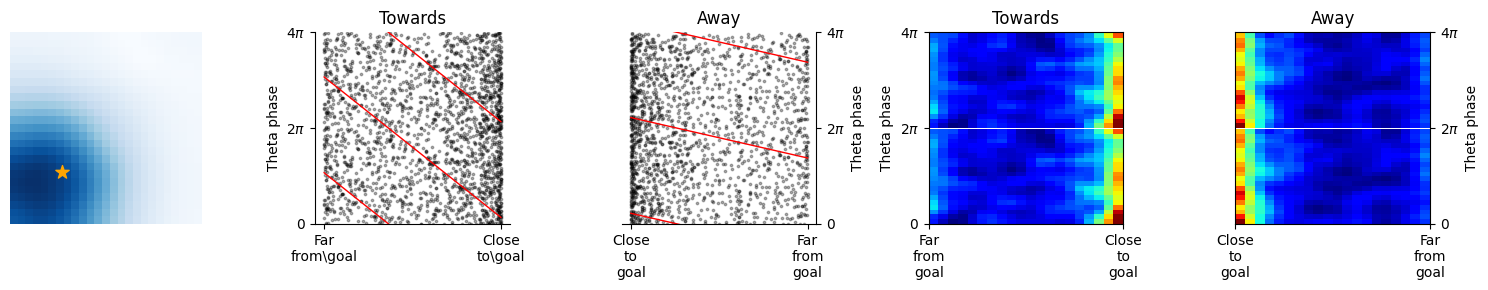

In [67]:
# variable needed: cellindex, pc_activity, Position, goal_loc, theta_phase
# np.random.seed(11)   
addfitline = True

fig = plt.figure(figsize=(15,3), dpi=100)
gs = gridspec.GridSpec(1, 5)

cellindex = [17, 18]

ax = plt.subplot(gs[0])
#tuning map of a cell

Position_norm = (Position - Position.min() - 1e-5)/(Position.max() - Position.min())
dim = num//2
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          shift = 0,
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)
ax.imshow(tuningMap, cmap='Blues', origin='lower')

#mark the goal location
goal_x = (goal_loc[0]- Position.min())/(Position.max() - Position.min())*dim
goal_y = (goal_loc[1]- Position.min())/(Position.max() - Position.min())*dim

ax.scatter(goal_x, goal_y, color='Orange', marker='*', s=100)

ax.axis('off')


####################################################################################################

#Phase against distance to goal

ax = plt.subplot(gs[1])
Dist2G = []
SpikePhase = []
RelativeDirection = []

r = pc_activity[:, cellindex[0], cellindex[1]] * 1000 #ms to s

for start, end in decreasing_periods:
    for i in range(start, end):
        total_dist = np.linalg.norm(Position[start]-goal_loc) - np.linalg.norm(Position[end]-goal_loc)
        #get the distance to goal_loc
        dist_i = np.linalg.norm(Position[i] - goal_loc)-np.linalg.norm(Position[end] - goal_loc)
        dist_i = dist_i/total_dist
        # print(dist_i)
        #get the vec pointing from Position to goal_loc
        vec = goal_loc - Position[i]
        #get the angle between vec and moving direction
        angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[i, 1], Vel[i, 0])
        angle = np.degrees(angle) % 360

        #get the phase at current time step i
        phase_i = theta_phase[i]*np.pi*2

        spikes = np.random.poisson(r[i]*dt*5)
        if spikes > 0:
            #save dist_i and phase_i
            Dist2G.append(dist_i)
            SpikePhase.append(phase_i)
            RelativeDirection.append(angle)


Dist2G = np.asarray(Dist2G)
SpikePhase = np.asarray(SpikePhase)

ax.scatter(Dist2G, SpikePhase, s=3, color='black', alpha=0.3)

ax.scatter(Dist2G, SpikePhase+2*np.pi, s=3, color='black', alpha=0.3)
# Create a 2D histogram for heat map

circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=-2, max_slope=2, bootstrap_iter=3000, return_pval=True)

if addfitline:
    # Plot the circular-linear regression
    x = np.linspace(0, 1, 100)
    y = 2 * np.pi * slope * x + phi0
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 4*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #substrac intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)  

#flip x axis with small values on the right and large values on the left
# Flip the x-axis
ax.invert_xaxis()

# ax.set_xlim(0, 1)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Close\nto\goal', 'Far\nfrom\goal'])

# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
ax.set_ylabel('Theta phase', fontsize=10)
# #activity colorba
ax.set_ylim(0, 4*np.pi)
ax.set_yticks([0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   
ax.set_title('Towards')

sns.despine()


####################################################################################################
ax = plt.subplot(gs[3])

heatmap, xedges, yedges = np.histogram2d(Dist2G, SpikePhase, bins=[20, 20])
from scipy.ndimage import gaussian_filter
# Smooth the heatmap using a Gaussian filter
heatmap_smooth = gaussian_filter(heatmap, sigma=1) 
# Plot the heat map
X, Y = np.meshgrid(xedges, yedges)
pcm = ax.pcolormesh(X, Y, heatmap_smooth.T, shading='auto', cmap='jet')
heatmap, xedges, yedges = np.histogram2d(Dist2G, SpikePhase+2*np.pi, bins=[20, 20])
heatmap_smooth = gaussian_filter(heatmap, sigma=1)
X, Y = np.meshgrid(xedges, yedges)
pcm = ax.pcolormesh(X, Y, heatmap_smooth.T, shading='auto', cmap='jet')

#flip x axis with small values on the right and large values on the left
# Flip the x-axis
ax.invert_xaxis()

# ax.set_xlim(0, 1)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])

# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
ax.set_ylabel('Theta phase', fontsize=10)
# #activity colorba
ax.set_ylim(0, 4*np.pi)
ax.set_yticks([0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   
ax.set_title('Towards')

####################################################################################################

ax = plt.subplot(gs[2])
Dist2G = []
SpikePhase = []
RelativeDirection = []

r = pc_activity[:, cellindex[0], cellindex[1]] * 1000 #ms to s

for start, end in increasing_periods:
    for i in range(start, end):
        total_dist = np.linalg.norm(Position[end]-goal_loc) - np.linalg.norm(Position[start]-goal_loc)
        #get the distance to goal_loc
        dist_i = np.linalg.norm(Position[i] - goal_loc)-np.linalg.norm(Position[start] - goal_loc)
        # print(dist_i)
        dist_i = dist_i/total_dist        
        #get the distance to goal_loc
        # dist_i = np.linalg.norm(Position[i] - goal_loc)

        #get the vec pointing from Position to goal_loc
        vec = goal_loc - Position[i]
        #get the angle between vec and moving direction
        angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[i, 1], Vel[i, 0])
        angle = np.degrees(angle) % 360

        #get the phase at current time step i
        phase_i = theta_phase[i]*np.pi*2

        spikes = np.random.poisson(r[i]*dt*5)
        if spikes > 0:
            #save dist_i and phase_i
            Dist2G.append(dist_i)
            SpikePhase.append(phase_i)
            RelativeDirection.append(angle)


Dist2G = np.asarray(Dist2G)
SpikePhase = np.asarray(SpikePhase)

ax.scatter(Dist2G, SpikePhase, s=3, color='black', alpha=0.3)

ax.scatter(Dist2G, SpikePhase+2*np.pi, s=3, color='black', alpha=0.3)

circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=-2, max_slope=2, bootstrap_iter=3000, return_pval=True)

if addfitline:
    # Plot the circular-linear regression
    x = np.linspace(0, 1, 100)
    y = 2 * np.pi * slope * x + phi0
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 4*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #substrac intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)  

# ax.set_xlim(0, 1)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])
# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
#show y axis, ticks labels on the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
    
ax.set_ylabel('Theta phase', fontsize=10)
ax.set_ylim(0, 4*np.pi)
ax.set_yticks([0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   
ax.set_title('Away')

#despine the left and top
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)


####################################################################################################
ax = plt.subplot(gs[4])

heatmap, xedges, yedges = np.histogram2d(Dist2G, SpikePhase, bins=[20, 20])

# Smooth the heatmap using a Gaussian filter
heatmap_smooth = gaussian_filter(heatmap, sigma=1) 
# Plot the heat map
X, Y = np.meshgrid(xedges, yedges)
pcm = ax.pcolormesh(X, Y, heatmap_smooth.T, shading='auto', cmap='jet')
heatmap, xedges, yedges = np.histogram2d(Dist2G, SpikePhase+2*np.pi, bins=[20, 20])
heatmap_smooth = gaussian_filter(heatmap, sigma=1)
X, Y = np.meshgrid(xedges, yedges)
pcm = ax.pcolormesh(X, Y, heatmap_smooth.T, shading='auto', cmap='jet')

# ax.set_xlim(0, 1)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])
# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
#show y axis, ticks labels on the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
    
ax.set_ylabel('Theta phase', fontsize=10)
ax.set_ylim(0, 4*np.pi)
ax.set_yticks([0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   
ax.set_title('Away')

####################################################################################################


plt.tight_layout()



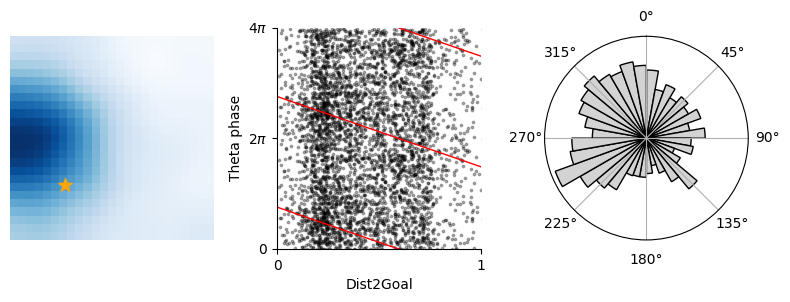

In [9]:
# variable needed: cellindex, pc_activity, Position, goal_loc, theta_phase

addfitline = True

fig = plt.figure(figsize=(8,3), dpi=100)
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

cellindex = [15, 24]

ax = plt.subplot(gs[0])
#tuning map of a cell

Position_norm = (Position - Position.min() - 1e-5)/(Position.max() - Position.min())
dim = num//2
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          shift = 0,
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)
ax.imshow(tuningMap, cmap='Blues', origin='lower')

#mark the goal location
goal_x = (goal_loc[0]- Position.min())/(Position.max() - Position.min())*dim
goal_y = (goal_loc[1]- Position.min())/(Position.max() - Position.min())*dim

ax.scatter(goal_x, goal_y, color='Orange', marker='*', s=100)

ax.axis('off')


####################################################################################################

#Phase against distance to goal

ax = plt.subplot(gs[1])
Dist2G = []
SpikePhase = []
RelativeDirection = []

r = pc_activity[:, cellindex[0], cellindex[1]] * 1000 #ms to s

for i in range(len(Position)):
    #get the distance to goal_loc
    dist_i = np.linalg.norm(Position[i] - goal_loc)
    # dist_i = np.where(dist_i > 0.5, 1.0 - dist_i, dist_i)
    
    #get the vec pointing from Position to goal_loc
    vec = goal_loc - Position[i]
    #get the angle between vec and moving direction
    angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[i, 1], Vel[i, 0])
    angle = np.degrees(angle) % 360
    
    #get the phase at current time step i
    phase_i = theta_phase[i]*np.pi*2
    
    spikes = np.random.poisson(r[i]*dt*5)
    if spikes > 0:
        #save dist_i and phase_i
        Dist2G.append(dist_i)
        SpikePhase.append(phase_i)
        RelativeDirection.append(angle)

Dist2G = np.asarray(Dist2G)
SpikePhase = np.asarray(SpikePhase)

ax.scatter(Dist2G, SpikePhase, s=3, color='black', alpha=0.3)

ax.scatter(Dist2G, SpikePhase+2*np.pi, s=3, color='black', alpha=0.3)

circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=-2, max_slope=2, bootstrap_iter=3000, return_pval=True)

if addfitline:
    # Plot the circular-linear regression
    x = np.linspace(-np.pi, np.pi, 100)
    y = 2 * np.pi * slope * x + phi0
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 4*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #substrac intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)  

# ax[0].set_xlabel('Head direction')
ax.set_xlabel('Dist2Goal', fontsize=10)
ax.set_ylabel('Theta phase', fontsize=10)
#activity colorbar
ax.set_xlim(0, 1)
ax.set_xticks([0, 1])
ax.set_ylim(0, 4*np.pi)
ax.set_yticks([0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   

sns.despine()

####################################################################################################
#ConSink
ax = plt.subplot(gs[2], projection='polar')
#plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
ax.hist(np.radians(RelativeDirection), bins=36, color='lightgrey', edgecolor='black')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])
plt.tight_layout()


Processing cell index:  15 15
Processing cell index:  15 17
Processing cell index:  15 19
Processing cell index:  15 21
Processing cell index:  15 23
Processing cell index:  15 25
Processing cell index:  15 27
Processing cell index:  15 29
Processing cell index:  15 31
Processing cell index:  15 33
Processing cell index:  17 15
Processing cell index:  17 17
Processing cell index:  17 19
Processing cell index:  17 21
Processing cell index:  17 23
Processing cell index:  17 25
Processing cell index:  17 27
Processing cell index:  17 29
Processing cell index:  17 31
Processing cell index:  17 33
Processing cell index:  19 15
Processing cell index:  19 17
Processing cell index:  19 19
Processing cell index:  19 21
Processing cell index:  19 23
Processing cell index:  19 25
Processing cell index:  19 27
Processing cell index:  19 29
Processing cell index:  19 31
Processing cell index:  19 33
Processing cell index:  21 15


KeyboardInterrupt: 

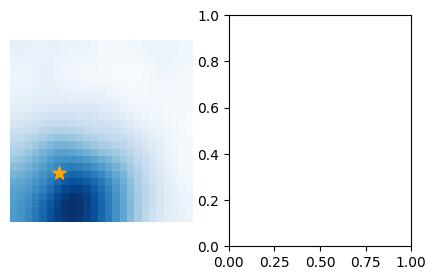

In [10]:
# variable needed: cellindex, pc_activity, Position, goal_loc, theta_phase

#for cell index x vary from 0-49 and y vary from 0-49, plot the tuning map and the phase of spikes at each time step

all_clcc = []
all_RelativeDirection = []
for xi in range(15, 35, 2):
    for yi in range(15, 35, 2):
        print('Processing cell index: ', xi, yi)
        cellindex = [xi, yi]

        fig = plt.figure(figsize=(8,3), dpi=100)
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])
        
        ####################################################################################################
        ax = plt.subplot(gs[0])
        #plot the tuning map
        Position_norm = (Position - Position.min() - 1e-5)/(Position.max() - Position.min())
        dim = num//2
        tuningMap = get_tuningMap(pc_activity, 
                                    Position_norm, 
                                    cellindex_x=cellindex[0],
                                    cellindex_y=cellindex[1],
                                    shift = 0,
                                    filter=True,
                                    samples_per_sec=1000,
                                    dim=dim)
        ax.imshow(tuningMap, cmap='Blues', origin='lower')

        #mark the goal location
        goal_x = (goal_loc[0]- Position.min())/(Position.max() - Position.min())*dim
        goal_y = (goal_loc[1]- Position.min())/(Position.max() - Position.min())*dim
        ax.scatter(goal_x, goal_y, color='Orange', marker='*', s=100)

        ax.axis('off')


        ####################################################################################################
        #Phase against distance to goal
        ax = plt.subplot(gs[1])
        
        Dist2G = []
        SpikePhase = []
        RelativeDirection = []

        r = pc_activity[:, cellindex[0], cellindex[1]] * 1000 #ms to s

        for i in range(len(Position)):
            #get the distance to goal_loc
            dist_i = np.linalg.norm(Position[i] - goal_loc)
            # dist_i = np.where(dist_i > 0.5, 1.0 - dist_i, dist_i)
  
            #get the vec pointing from Position to goal_loc
            vec = goal_loc - Position[i]
            #get the angle between vec and moving direction
            angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[i, 1], Vel[i, 0])
            angle = np.degrees(angle) % 360
            
            #get the phase at current time step i
            phase_i = theta_phase[i]*np.pi*2
            
            spikes = np.random.poisson(r[i]*dt*5)
            if spikes > 0:
                #save dist_i and phase_i
                Dist2G.append(dist_i)
                SpikePhase.append(phase_i)
                RelativeDirection.append(angle)
                all_RelativeDirection.append(angle)

        Dist2G = np.asarray(Dist2G)
        SpikePhase = np.asarray(SpikePhase)

        ax.scatter(Dist2G, SpikePhase, s=3, color='black', alpha=0.3)

        ax.scatter(Dist2G, SpikePhase+2*np.pi, s=3, color='black', alpha=0.3)

        circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=-2, max_slope=2, bootstrap_iter=3000, return_pval=True)
        all_clcc.append(circ_lin_corr)
        if True:
            # Plot the circular-linear regression
            x = np.linspace(-np.pi, np.pi, 100)
            y = 2 * np.pi * slope * x + phi0
            ax.plot(x, y, color='red', linewidth=1)
            #add intercepr of 2*pi, and plot the line again
            y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
            ax.plot(x, y, color='red', linewidth=1)
            #add intercepr of 4*pi, and plot the line again
            y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
            ax.plot(x, y, color='red', linewidth=1)
            #substrac intercepr of 2*pi, and plot the line again
            y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
            ax.plot(x, y, color='red', linewidth=1) 

        # ax[0].set_xlabel('Head direction')
        ax.set_xlabel('Dist2Goal', fontsize=10)
        ax.set_ylabel('Theta phase', fontsize=10)
        #activity colorbar
        ax.set_xlim(0, 1)
        ax.set_xticks([0, 1])
        ax.set_ylim(0, 4*np.pi)
        ax.set_yticks([0, 2*np.pi, 4*np.pi])
        ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   

        sns.despine()
        
        ####################################################################################################
        #ConSink
        ax = plt.subplot(gs[2], projection='polar')
        #plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
        ax.hist(np.radians(RelativeDirection), bins=36, color='lightgrey', edgecolor='black')
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_yticks([])

        plt.tight_layout()
        
        plt.savefig('./figures/phasevsgoaldist/Cell_'+str(cellindex[0])+'_'+str(cellindex[1])+'.png', dpi=300)
        
        plt.close()

Wilcoxon signed-rank test: W = 1186.000, p = 0.000


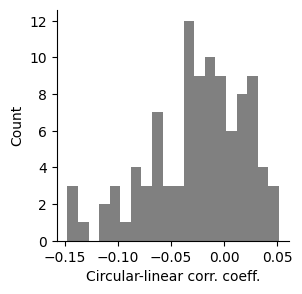

In [ ]:
#plot histogram of circ_lin_corr
fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=100)
ax.hist(all_clcc, bins=20, color='grey')
ax.set_xlabel('Circular-linear corr. coeff.')
ax.set_ylabel('Count')
sns.despine()

#check if the circular-linear correlation is significantly different from 0 
#using wilcoxon signed-rank test
from scipy.stats import wilcoxon
w, p = wilcoxon(all_clcc)
print('Wilcoxon signed-rank test: W = %.3f, p = %.3f' % (w, p))